In [1]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

# Input elements properties

In [2]:
#Input elements
number_elements = int(input("Enter the number of elements you want to add "))
tags = []
sizes = []

Enter the number of elements you want to add 2


In [3]:
for element in range(number_elements):
    width = int(input("Enter the width of the element "))  # canvas width
    height = int(input("Enter the height of the element ")) # canvas height
    sizes.append((width, height))
    tag = input("Enter the label for the sketch ")
    tags.append(tag)
    center = height//2
    white = (255, 255, 255) # canvas back

    def save():
        # save image to hard drive
        filename = "sketch2photo/item"+str(element)+".jpg"
        output_image.save(filename)
        master.destroy()

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=5)
        draw.line([x1, y1, x2, y2],fill="black",width=5)

    master = Tk()

    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width+100, height=height+100, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width+100, height+100), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)

    # add a button to save the image
    button=Button(text="save",command=save)
    button.pack()

    master.mainloop()

Enter the width of the element 150
Enter the height of the element 150
Enter the label for the sketch man throw
Enter the width of the element 50
Enter the height of the element 50
Enter the label for the sketch frisbee


# Background Tag

In [4]:
background_tag = input("Enter the tag for the background ")

Enter the tag for the background ground


In [5]:
tags.append(background_tag)

In [6]:
# Combine the images into one

from PIL import Image

image_background = Image.new('RGB', (512, 512), (255, 255, 255))  # Base Image
desired_locations = []
for images in range(number_elements):
    img_address = "sketch2photo/item"+str(images)+".jpg"
    curr_image = Image.open(img_address)
    curr_image.resize(sizes[images], Image.ANTIALIAS)
    x = int(input("Enter x coordinate of desired location of item {} ".format(images)))
    y = int(input("Enter y coordinate of desired location of item {} ".format(images)))
    desired_locations.append((x, y))
    image_background.paste(curr_image, (x,y))

Enter x coordinate of desired location of item 0 10
Enter y coordinate of desired location of item 0 100
Enter x coordinate of desired location of item 1 300
Enter y coordinate of desired location of item 1 50


# User input Image

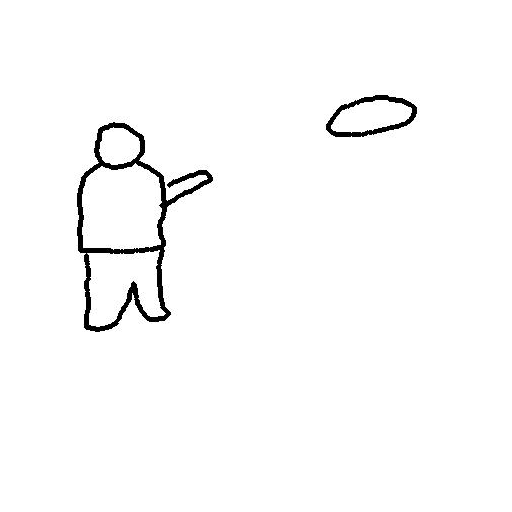

In [7]:
image_background

# Scraping Images from Google

In [8]:
# Search Google for images with the given tags 
import selenium
from selenium import webdriver
import time
import requests
import os
from PIL import Image
import io
import hashlib
# This is the path I use
#DRIVER_PATH = '/Users/anand/Desktop/chromedriver'
# Put the path for your ChromeDriver here
DRIVER_PATH = 'webdriver/chromedriver'

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

def persist_image(folder_path:str,file_name:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        folder_path = os.path.join(folder_path,file_name)
        if os.path.exists(folder_path):
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        else:
            os.mkdir(folder_path)
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [9]:
op = webdriver.ChromeOptions()
op.add_argument('headless')
wd = webdriver.Chrome(options=op, executable_path=DRIVER_PATH)
queries = tags 
for query in queries:
    wd.get('https://google.com')
    search_box = wd.find_element_by_css_selector('input.gLFyf')
    search_box.send_keys(query)
    links = fetch_image_urls(query,15,wd)
    images_path = 'scraped_photos'
    for i in links:
        persist_image(images_path,query,i)
wd.quit()

Found: 100 search results. Extracting links from 0:100
Found: 15 image links, done!
SUCCESS - saved https://thumbs.dreamstime.com/z/man-throwing-football-10769231.jpg - as scraped_photos\man throw\5afeb43d14.jpg
SUCCESS - saved https://c8.alamy.com/comp/X169HD/athlete-man-throwing-a-javelin-X169HD.jpg - as scraped_photos\man throw\96ca914293.jpg
SUCCESS - saved https://c8.alamy.com/comp/CN665H/mongolian-man-throw-the-rope-khuduu-aral-khentii-province-mongolia-CN665H.jpg - as scraped_photos\man throw\5207874cfd.jpg
SUCCESS - saved https://thumbs.dreamstime.com/z/man-throwing-shot-put-2136446.jpg - as scraped_photos\man throw\b1c012cff8.jpg
SUCCESS - saved https://image.shutterstock.com/image-photo/business-man-throwing-paper-plane-260nw-328140548.jpg - as scraped_photos\man throw\5798f64339.jpg
SUCCESS - saved https://previews.123rf.com/images/stocknoiiz/stocknoiiz1407/stocknoiiz140700004/30662569-man-throw-stone.jpg - as scraped_photos\man throw\0647716b31.jpg
SUCCESS - saved https://m

In [10]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2
from utils import detect_horizon_line
import glob
import sklearn
from matplotlib import pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from tqdm import tqdm

# Selecting Background Images

In [11]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T).reshape(1,-1)
    return mahal.diagonal()

In [12]:
# Finalize Background Images
final_background_images = []

# Read the scraped background images
background_image_list = []

for filename in glob.glob('scraped_photos/' + str(tags[number_elements]) + '/' + '*.jpg'): 
    im = PIL.Image.open(filename)
    background_image_list.append(im)
    
    
## 1. Content Consistency Filtering

mahalanobis_distances = []

for imgs in tqdm(background_image_list):
    
    img = np.array(imgs)

    # image shape
    shape = img.shape

    # reshaping image 
    reshape_img = np.reshape(imgs, [-1, 3])
    
    bandwidth = estimate_bandwidth(reshape_img, quantile=0.1, n_samples=100)
    
    msc = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    
    msc.fit(reshape_img)
    
    counts = np.bincount(msc.labels_)
    max_count = np.argmax(counts)
    
    data = np.array([reshape_img[i] for i in range(len(msc.labels_)) if msc.labels_[i]== max_count ])
    
    # Calculate Mahalanobis Distance
    
    indices = np.random.choice(len(reshape_img), size= int(0.01*len(reshape_img)), replace=False)
    
    curr_distance = np.array([mahalanobis(x=reshape_img[i], data=data) for i in indices])
    
    mahalanobis_distances.append(np.mean(curr_distance))

# Select Images with the least normalized distance

mahalanobis_distances = sklearn.preprocessing.minmax_scale(np.array(mahalanobis_distances), feature_range=(0, 1), axis=0, copy=True)
lowest_maha_dist = np.argsort(mahalanobis_distances)[:10]

background1 = [background_image_list[i] for i in lowest_maha_dist]

100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [1:20:39<00:00, 345.71s/it]


In [ ]:
# 2. Uncluttered Region Filtering

import skimage.segmentation as seg
import skimage.filters as filters

no_horizon = []
horizon = []
selected_images1 = []
for i, img in enumerate(background1):
    width, height = img.size
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    try:
        horizon_x1, horizon_x2, horizon_y1, horizon_y2 = (
            detect_horizon_line(image_grayscale)
        )
        p1 = (horizon_x1, horizon_y1)
        p2 = (horizon_x2, horizon_y2)
        p3 = (width/2, height)
        p1 = np.asarray(p1)
        p2 = np.asarray(p2)
        p3 = np.asarray(p3)
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        if d <= 0.5 * height :
            horizon.append(i)
            selected_images1.append(img)
        
    except :
        print('Horizon not found for this image')
        no_horizon.append(i)
        

segment_counts = []
for i, img in enumerate(selected_images1):
    image_slic = seg.slic(img,n_segments=155, start_label=1)
    labels = np.unique(image_slic).size
    segment_counts.append(labels)
    
segment_count_normalized = sklearn.preprocessing.minmax_scale(np.array(segment_counts), feature_range=(0, 1), axis=0, copy=True)
selected_mahalanobis = np.array([mahalanobis_distances[i] for i in horizon])

combined_cost = segment_count_normalized + (0.3 * selected_mahalanobis)

least_segment_indices = np.argsort(combined_cost)[:5]

# Final Selected Background Images
selected_background_images = [selected_images1[i] for i in least_segment_indices]

# Selecting Scene Items

In [15]:
def normalize_filled(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours,hierachy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # fill shape
    cv2.fillPoly(img, pts=contours, color=(255,255,255))
    bounding_rect = cv2.boundingRect(contours[0])
    img_cropped_bounding_rect = img[bounding_rect[1]:bounding_rect[1] + bounding_rect[3], bounding_rect[0]:bounding_rect[0] + bounding_rect[2]]
    
    return img_cropped_bounding_rect

In [ ]:
selected_scene_items = []

for num_elements in range(number_elements):
    scores = []
    extracted_images = []
    for filename in glob.glob('scraped_photos/' + str(tags[num_elements]) + '/' + '*.jpg'): 
        im = PIL.Image.open(filename)
        img1 = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img = cv2.GaussianBlur(img1,(5,5), 0)
        gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)


        saliency = cv2.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(img1)
        saliencyMap = (saliencyMap*255).astype("uint8")
        threshMap = cv2.threshold(saliencyMap, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        rect = cv2.boundingRect(threshMap)


        l_mean = np.mean(gray_lab[:,:,0])
        a_mean = np.mean(gray_lab[:,:,1])
        b_mean = np.mean(gray_lab[:,:,2])
        lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
        lab = np.sum(lab,axis=2)
        max_ = np.max(lab)
        lab = lab/max_
        image2 = gray_lab
        mask = np.zeros(image2.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        try:
            cv2.grabCut(image2,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
            mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
            image2 = img1*mask2[:,:,np.newaxis]

            # Countour Matching
            contour_current = normalize_filled(image2)

            img_address = "sketch2photo/item"+str(num_elements)+".jpg"
            curr_image = PIL.Image.open(img_address)
            curr_image.resize(sizes[num_elements], PIL.Image.ANTIALIAS)
            curr_image = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
            contour_item = normalize_filled(curr_image)
            score = cv2.matchShapes(contour_current, contour_item, 1, 0.0)
            scores.append(score)
            extracted_images.append(image2)
        except:
            print("Error for this image")
            
    least_score = np.argmin(np.array(scores))
    selected_scene_items.append(extracted_images[least_score])

In [22]:
selected_background_images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x678 at 0x13A02A22898>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1333 at 0x13A02A22C18>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x459 at 0x13A02A22AC8>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=843x465 at 0x13A02A22A58>]

# Output Images

In [70]:
# Output Images 

final_images = []
scene_items_plot = []
for bacground_img in selected_background_images:
    count = 0 
    for ele in range(number_elements):
        
        src = PIL.Image.fromarray(selected_scene_items[ele])
        
        if count == 0:
            dst = bacground_img
            count += 1
            
        src = cv2.cvtColor(np.array(src), cv2.COLOR_RGB2BGR)
        dst = cv2.cvtColor(np.array(dst), cv2.COLOR_RGB2BGR)
        
        src = cv2.resize(src, (sizes[ele]), interpolation= cv2.INTER_LINEAR)
        dst = cv2.resize(dst, (512, 512), interpolation= cv2.INTER_LINEAR)
        
        src_mask = np.zeros(src.shape, src.dtype)
        src_test = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        contours,hierachy = cv2.findContours(src_test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        poly = np.array(contours, np.int32)
        cv2.fillPoly(src_mask, poly, (255, 255, 255))

        width = int(desired_locations[ele][0] + sizes[ele][0]*0.5)
        height = int(desired_locations[ele][1] + sizes[ele][1]*0.5)
        center = (width, height)
        
        # Clone seamlessly.
        dst = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
    
    RGB_img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    final_images.append(dst)

# Output Visualisation 

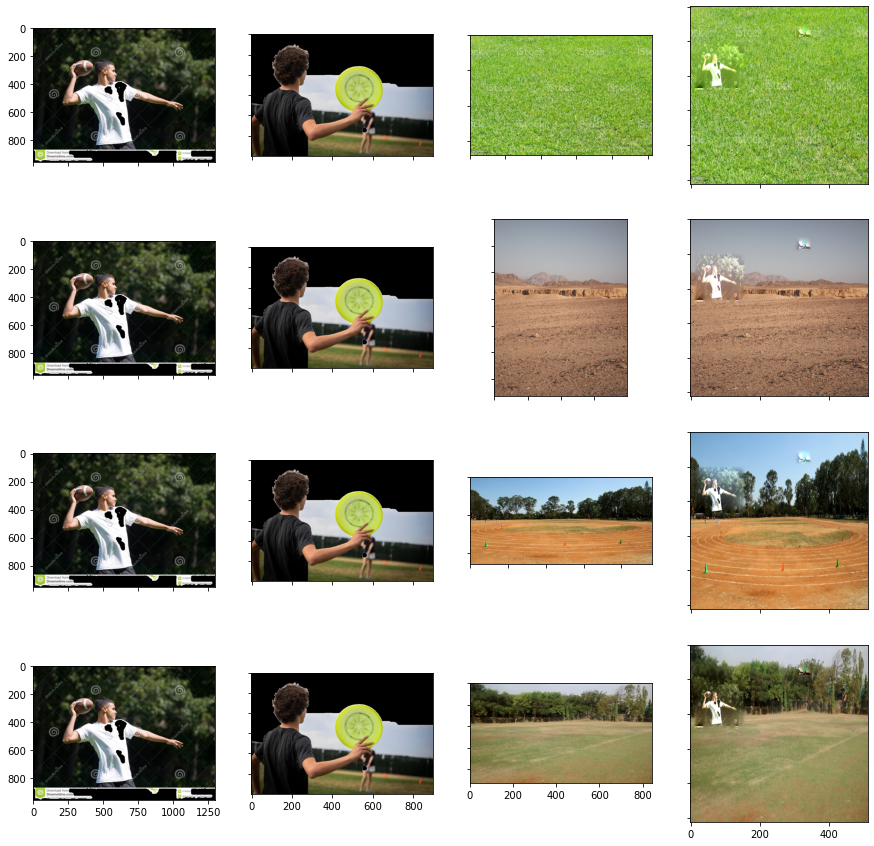

In [81]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))

for i in range(4):
    for j in range(4):
        if j == 0:
            axs[i, j].imshow(selected_scene_items[j])
        elif j == 1:
            axs[i, j].imshow(selected_scene_items[j])
        elif j == 2:
            axs[i, j].imshow(selected_background_images[i])
        elif j== 3:
            axs[i, j].imshow(final_images[i])





# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [47]:
len(final_images)

4